In [1]:
# get the directory of the files

import tkinter as tk
from tkinter import filedialog
import os

root = tk.Tk()
root.withdraw()
directory = os.path.dirname(filedialog.askopenfilename()) + '\\'

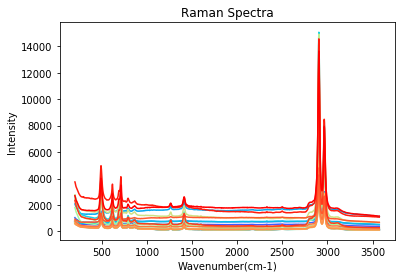

(3501, 2)
27


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import glob
from matplotlib.pyplot import cm
import numpy as np

files = glob.glob(directory + '*.CSV')
n = len(files)
colors = cm.rainbow(np.linspace(0, 1, n))              
plt.figure()

# Visulize all the data

for file, color in zip(files, colors):
    dataset = pd.read_csv(file)
    dataset.columns = ['wavenumber', 'intensity']
    x = dataset['wavenumber']
    y = dataset['intensity']
    plt.plot(x, y, color = color)
    plt.xlabel('Wavenumber(cm-1)')
    plt.ylabel('Intensity')
    plt.title('Raman Spectra')
plt.show()
print(dataset.shape)
print(len(files))

In [4]:
# baseline subtraction to remove the background signal (Asymmetric Least Squares method) 
# by P.Eilers and H.Boelens in 2015.
# loss function: S = weight* SMSQ(y-z) + lambda*sum of 2nd derivative. 
# The first term is to measure the fit to the data and the second term is a penalty on non-smooth behavior of z
# a new parameter p is introduced to add more weight to the negative residues. w=p if y>z, and w = 1-p elsewise.
# tuning parameters: p for asymmetry (0.001, 0.1) and lambda for smoothness (10^2 to 10^9).

In [5]:

import numpy as np
from scipy.linalg import solveh_banded

def als_baseline(intensities, asymmetry_param=0.05, smoothness_param=1e6,
                 max_iters=10, conv_thresh=1e-5, verbose=False):
    '''Computes the asymmetric least squares baseline.
    * http://www.science.uva.nl/~hboelens/publications/draftpub/Eilers_2005.pdf

      smoothness_param: Relative importance of smoothness of the predicted response.
      asymmetry_param (p): if y > z, w = p, otherwise w = 1-p.
                       Setting p=1 is effectively a hinge loss.
    '''
    smoother = WhittakerSmoother(intensities, smoothness_param, deriv_order=2)
    # Rename p for concision.
    p = asymmetry_param
    # Initialize weights.
    w = np.ones(intensities.shape[0])
    for i in range(max_iters):
        z = smoother.smooth(w)
        mask = intensities > z
        new_w = p*mask + (1-p)*(~mask)
        conv = np.linalg.norm(new_w - w)
        if verbose:
            print(i+1, conv)
        if conv < conv_thresh:
            break
        w = new_w
    #else:
        #print('ALS did not converge in %d iterations' % max_iters)
    return z


class WhittakerSmoother(object):
    def __init__(self, signal, smoothness_param, deriv_order=1):
        self.y = signal
        assert deriv_order > 0, 'deriv_order must be an int > 0'
        # Compute the fixed derivative of identity (D).
        d = np.zeros(deriv_order*2 + 1, dtype=int)
        d[deriv_order] = 1
        d = np.diff(d, n=deriv_order)
        n = self.y.shape[0]
        k = len(d)
        s = float(smoothness_param)

        # Here be dragons: essentially we're faking a big banded matrix D,
        # doing s * D.T.dot(D) with it, then taking the upper triangular bands.
        diag_sums = np.vstack([np.pad(s*np.cumsum(d[-i:]*d[:i]), ((k-i,0),), 'constant')
            for i in range(1, k+1)])
        upper_bands = np.tile(diag_sums[:,-1:], n)
        upper_bands[:,:k] = diag_sums
        for i,ds in enumerate(diag_sums):
            upper_bands[i,-i-1:] = ds[::-1][:i+1]
        self.upper_bands = upper_bands

    def smooth(self, w):
        foo = self.upper_bands.copy()
        foo[-1] += w  # last row is the diagonal
        return solveh_banded(foo, w * self.y, overwrite_ab=True, overwrite_b=True)


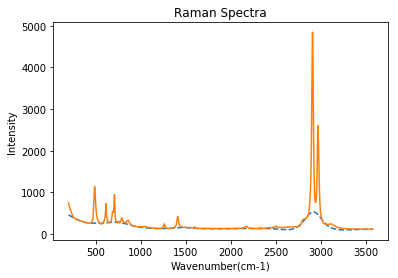

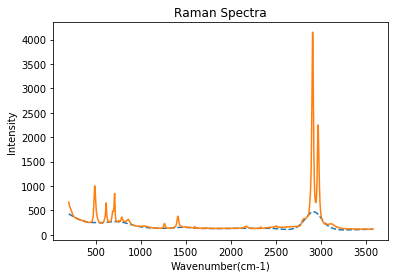

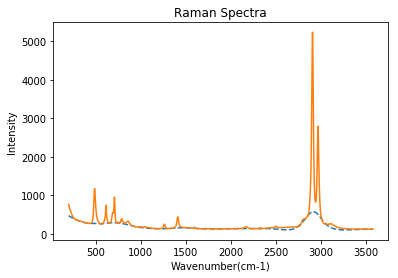

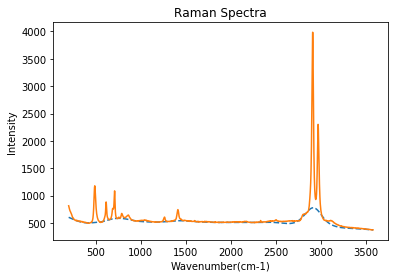

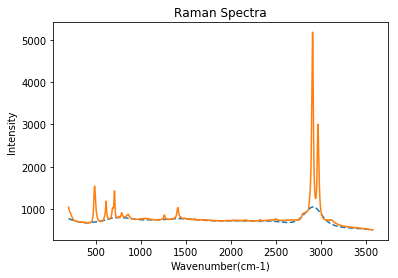

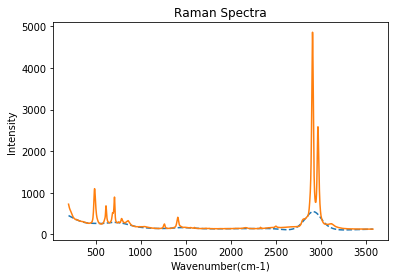

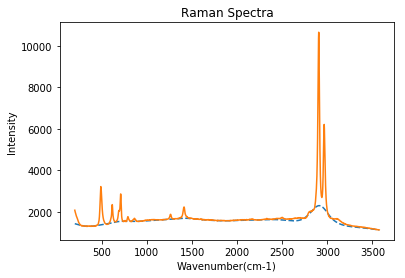

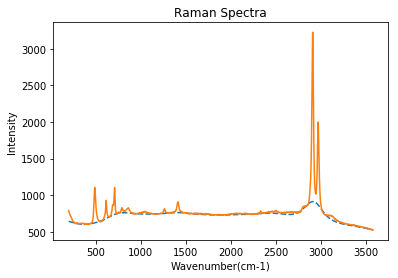

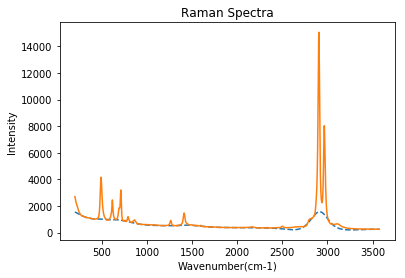

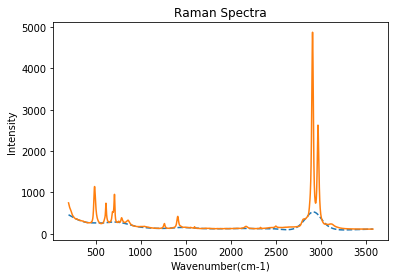

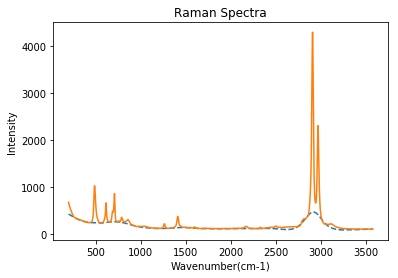

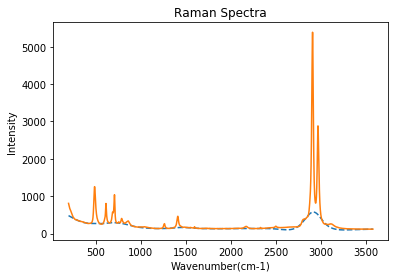

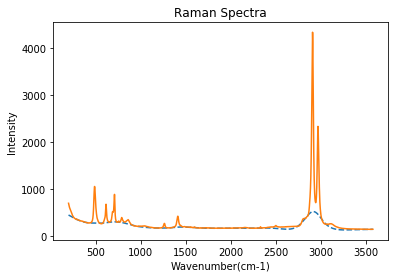

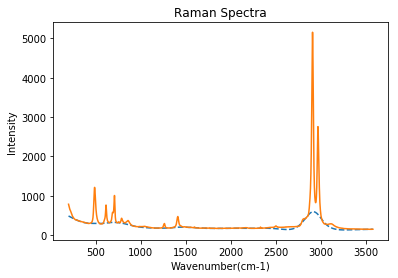

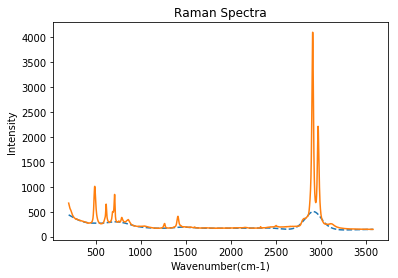

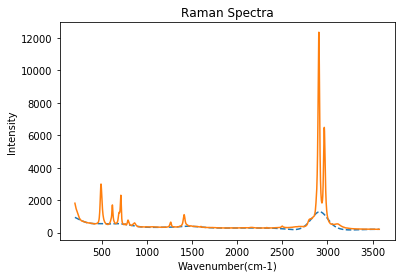

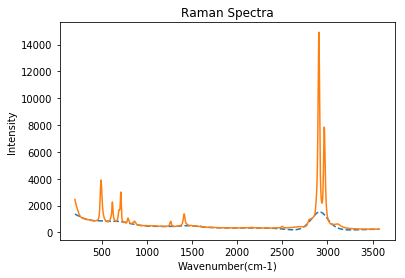

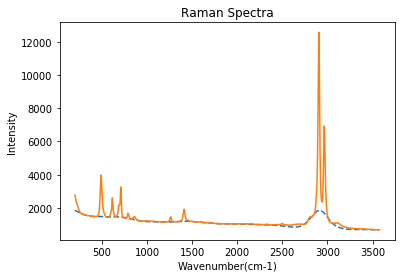

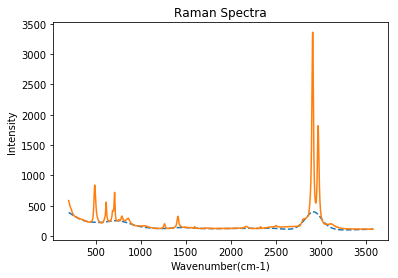

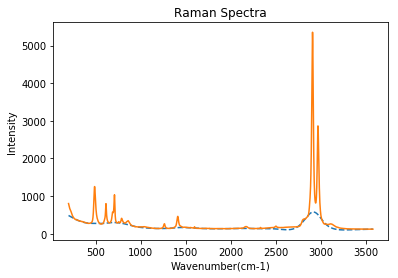

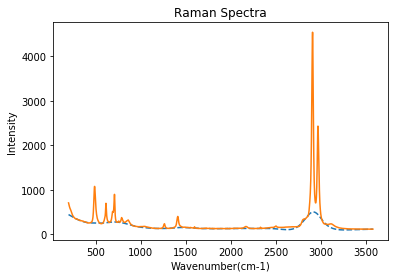

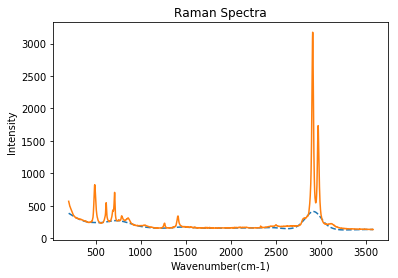

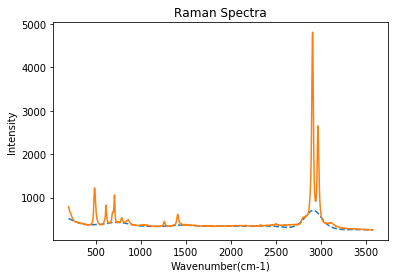

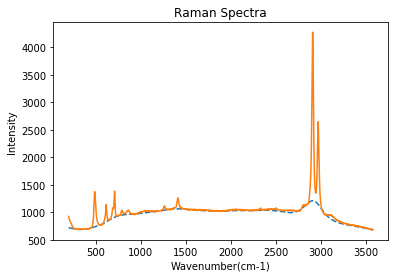

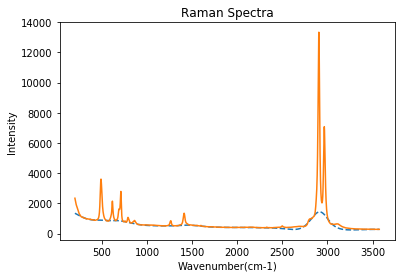

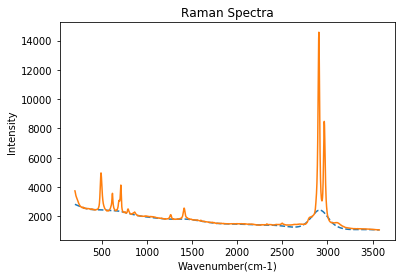

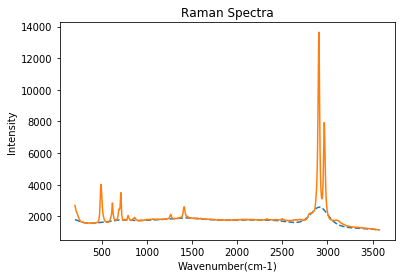

In [6]:
# plot individual spectrum and check the basline correction
for file, color in zip(files, colors):
    dataset = pd.read_csv(file)
    dataset.columns = ['wavenumber', 'intensity']
    x = dataset['wavenumber']
    y = dataset['intensity']
    
    z = als_baseline(y, asymmetry_param=0.01, smoothness_param=1e6,
                 max_iters=10, conv_thresh=1e-5, verbose=False)

    plt.plot(x, z, linestyle = '--')
    plt.plot(x, y)
    plt.xlabel('Wavenumber(cm-1)')
    plt.ylabel('Intensity')
    plt.title('Raman Spectra')
    plt.show()

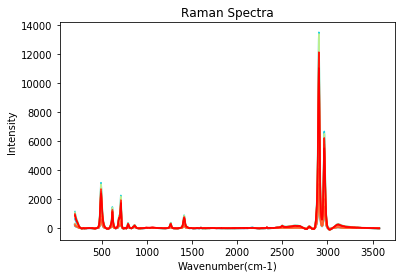

(3501, 28)

In [7]:
# remove the background signal and plot all the spectrum together

df = pd.DataFrame(np.empty((len(dataset), len(files)+1)))
df[0] = dataset['wavenumber']
i = 1
for file, color in zip(files, colors):
    dataset = pd.read_csv(file)
    dataset.columns = ['wavenumber', 'intensity']
    x = dataset['wavenumber']
    y = dataset['intensity']
    
    z = als_baseline(y, asymmetry_param=0.01, smoothness_param=1e6,
                 max_iters=10, conv_thresh=1e-5, verbose=False)

    plt.plot(x, y-z, color = color)
    plt.xlabel('Wavenumber(cm-1)')
    plt.ylabel('Intensity')
    plt.title('Raman Spectra')
    dataset['intensity'] -= z
    
    df[i] = dataset['intensity']
    i += 1

plt.show()
df.shape


In [8]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,200.1001,284.961136,241.571053,297.571752,210.729903,268.645828,273.519424,650.289759,149.014795,1155.595537,...,917.732393,195.105402,316.990380,261.929857,183.672926,269.722162,205.700846,995.347755,914.852336,897.181554
1,201.0644,277.091350,233.947640,289.743756,204.002696,260.644773,264.687823,628.207816,144.372664,1118.258476,...,890.952184,188.844671,308.153115,254.132434,177.219961,262.001521,198.490145,967.338997,884.875337,871.376158
2,202.0286,270.470460,225.270924,282.941957,199.178887,254.544715,257.628319,608.961866,141.762731,1088.054405,...,860.206967,183.272739,299.662947,249.304009,172.526094,255.849178,190.836042,939.118230,869.167329,844.329753
3,202.9928,264.466763,217.070202,276.587850,195.220772,249.374649,251.294807,592.573897,139.987393,1061.507299,...,829.988722,178.271801,291.680669,245.333275,168.727223,250.612126,183.947133,911.656433,858.107294,818.180321
4,203.9571,258.256448,211.045265,269.898724,190.792145,243.840567,244.350678,578.981890,137.530147,1034.411125,...,804.670423,173.589751,284.223373,239.678026,164.863640,245.522959,179.033511,885.505577,839.868205,794.294837


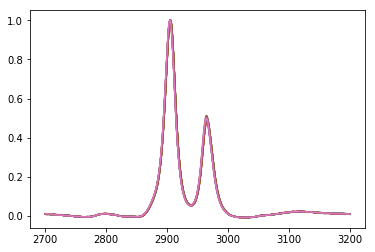

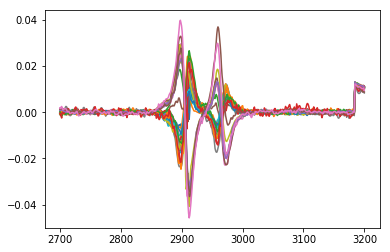

In [9]:
# normalize the highest peak to 1
# select spectrum between [2700, 3200] wavenumbers
df = df[(df[0]>=2700)&(df[0]<=3200)]

x_raw = df.iloc[:, 0].values
y_raw = df.iloc[:, 1:].values

plt.figure()
for i in range(len(files)):
    y_raw[:, i] = y_raw[:, i]/max(y_raw[:, i])
    plt.plot(x_raw, y_raw[:, i])
plt.show()

#mean subtraction and therefore the 1st PC component is not the mean
plt.figure()

for i in range(502):
    y_raw[i, :] = y_raw[i, :] - np.mean(y_raw[i, :])
i = 0
while i < len(files):
    plt.plot(x_raw, y_raw[:, i])
    i += 1
plt.show()


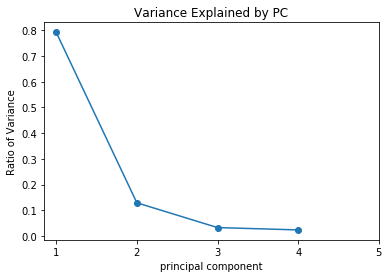

In [10]:
from sklearn.decomposition import PCA
n_components = 4

pca = PCA(n_components)
y_pca = pca.fit_transform(y_raw)
components = pca.components_
variance = pca.explained_variance_ratio_

plt.plot(range(1, len(variance)+1), variance, 'o', linestyle = '-')
plt.xticks(np.arange(1, 6, 1.0))
plt.xlabel('principal component')
plt.ylabel('Ratio of Variance')
plt.title('Variance Explained by PC')
plt.show()

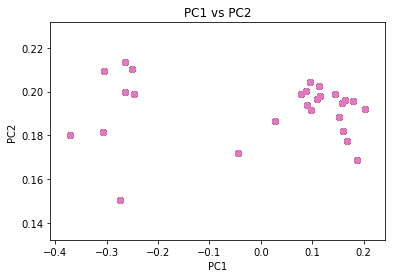

In [11]:
# plot the pc1 vs PC2
for i in range(len(files)):
    plt.scatter(components[0, :], components[1, :])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("PC1 vs PC2")
plt.show()

In [12]:
y_pca.shape

(519, 4)

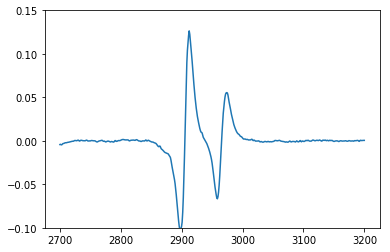

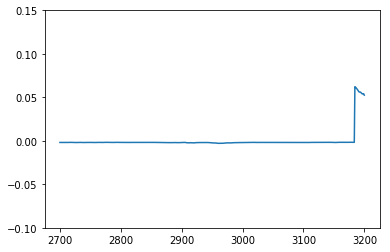

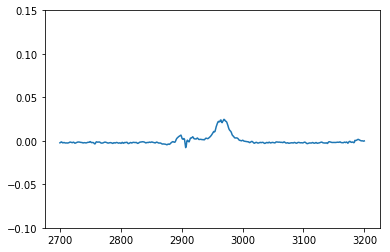

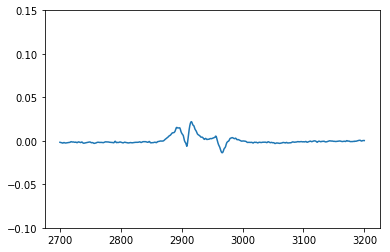

In [13]:
# plot PC1 component and PC2 component


for i in range(4):
    plt.plot(x_raw, y_pca[:, i])
    ax = plt.gca()
    ax.set_ylim(-0.10, 0.15)
    plt.show()

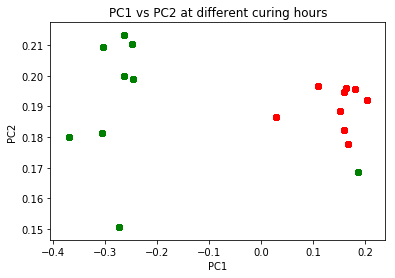

In [15]:
# plot the pc1 vs PC2 at different curing temperature
for i in range(9):
    plt.scatter(components[0, 3:6], components[1, 3:6], color = 'red', label = '2hrs curing time.')
    plt.scatter(components[0, 12:15], components[1, 12:15], color = 'red', label = '2hrs curing temp.')
    plt.scatter(components[0, 21:24], components[1, 21:24], color = 'red', label = '2hrs curing temp.')
    plt.scatter(components[0, 6:9], components[1, 6:9], color = 'green', label = '4hrs curing time.')
    plt.scatter(components[0, 15:18], components[1, 15:18], color = 'green', label = '4hrs curing temp.')
    plt.scatter(components[0, 24:27], components[1, 24:27], color = 'green', label = '4hrs curing temp.')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("PC1 vs PC2 at different curing hours")
plt.show()

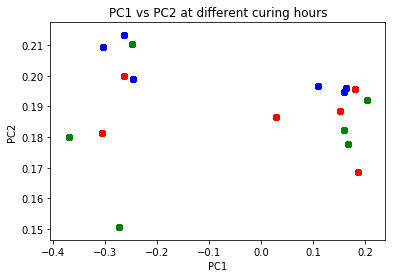

In [16]:
# plot the pc1 vs PC2 at different curing time
for i in range(9):
    plt.scatter(components[0, 3:9], components[1, 3:9], color = 'red', label = '120C curing temp.')
    plt.scatter(components[0, 12:18], components[1, 12:18], color = 'blue', label = '165C curing temp.')
    plt.scatter(components[0, 21:27], components[1, 21:27], color = 'green', label = '180C curing temp.')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("PC1 vs PC2 at different curing hours")
plt.show()